In [1]:
import scqubits as scq
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt


In [31]:
def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

In [117]:
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
def SNAIL():
    # omegas = 3*2*np.pi
    g3 = 0.1*2*np.pi
    
    s = annihilation(dims)
    sd = creation(dims)
    
    H = omegas*sd@s 
    Hnl = g3*(s+sd)@(s+sd)@(s+sd)
    
    phi_zpf = 0.5
    phi = phi_zpf*(s+sd)
    charge = -1j*(s-sd)/2/phi_zpf

    # Hs = H+Hnl
    # energy0,U = np.linalg.eigh(Hs)
    # energy0,U = sort_eigenpairs(energy0, U)
    # energy0 = energy0 - energy0[0]
    # Ud = U.transpose().conjugate()
    # Hs = Ud@Hs@U
    # Hs = Hs - Hs[0,0]*np.identity(dims)
    # phi_op = Ud@phi_op@U
    # charge_op = Ud@charge_op@U
    
    return H, Hnl, phi, charge

def fluxonium(flux1,flux2):
    print(EL1,EL2)
    fluxonium2 = scq.Fluxonium(
    EJ=4.9,
    EC=2,
    EL=EL1,
    cutoff = 210,
    flux = flux1,
    truncated_dim=d1
    )   
    fluxonium1 =  scq.Fluxonium(
    EJ=4.9,
    EC=1.7,
    EL=EL2,
    cutoff = 210,
    flux = flux2,
    truncated_dim=d2
    )
    
    H1 = fluxonium1.hamiltonian(energy_esys=True) * 2 * np.pi
    H2 = fluxonium2.hamiltonian(energy_esys=True) * 2 * np.pi
    H1 = H1 - np.identity(d1) * H1[0, 0]
    H2 = H2 - np.identity(d2) * H2[0, 0]
    phi1 = fluxonium1.phi_operator(energy_esys=True)
    phi2 = fluxonium2.phi_operator(energy_esys=True)
    print(H1,H2)
    return H1,H2,phi1,phi2
    
def fsf(flux1,flux2):
    Hs,Hnl,phis,charges = SNAIL()
    H1,H2,phi1,phi2 = fluxonium(flux1,flux2)
    If1 = np.identity(d1)
    If2 = np.identity(d2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs+Hnl, If2), If1)
    H2 = np.kron(np.kron(Is, H2), If1)
    H1 = np.kron(np.kron(Is, If2), H1)
    
    H_int1 = EL1 *  np.kron(np.kron(phis, phi2), If1)*2*np.pi/2
    H_int2 = -EL2 *  np.kron(np.kron(phis, If2),phi1)*2*np.pi/2

    H = Hs + H2 + H1 + H_int1 + H_int2 
    print(Hs,H2,H1,H_int1,H_int2)
    Hc = np.kron(np.kron(charges, If2), If1)
    
    
    return H,Hc

def bs(flux1,flux2):
    # omegas = 6*2*np.pi
    g3 = 0.1*2*np.pi
    s = annihilation(dims)
    sd = creation(dims)
    Hs = omegas*sd@s 
    Hnl = g3*(s+sd)@(s+sd)
    phi_zpf = 0.5
    phis = phi_zpf*(s+sd)
    charges = -1j*(s-sd)/2/phi_zpf
    
    H1,H2,phi1,phi2 = fluxonium(flux1,flux2)
    If1 = np.identity(d1)
    If2 = np.identity(d2)
    Is = np.identity(dims)
    
    Hs = np.kron(np.kron(Hs, If2), If1)
    Hnl = np.kron(np.kron(Hnl, If2), If1)
    H2 = np.kron(np.kron(Is, H2), If1)
    H1 = np.kron(np.kron(Is, If2), H1)
    
    H_int1 = EL1 *  np.kron(np.kron(phis, phi2), If1)*2*np.pi
    H_int2 = EL2 *  np.kron(np.kron(phis, If2),phi1)*2*np.pi

    H = Hs + H2 + H1 + H_int1 + H_int2 
    eigenvals, U = np.linalg.eigh(H)
    
    energy0,U = np.linalg.eigh(H)
    energy0,U = sort_eigenpairs(energy0, U)
    energy0 = energy0 - energy0[0]
    Ud = U.transpose().conjugate()
    result = Ud@Hnl@U
    app = (phi1[0,1]*EL1*2*np.pi*phi_zpf*2/omegas)*(phi2[0,1]*EL2*2*np.pi*phi_zpf*2/omegas)*2*6*g3/2/np.pi*-1
    return result*2*6*g3/2/np.pi,app

def l1l2l3(flux1 , flux2):
    H , Hc = fsf(flux1,flux2)
    energy0, U = np.linalg.eigh(H)
    energy0 -= energy0[0]
    l1 = energy0[1]
    l2 = energy0[2]
    l3 = energy0[3]
    return l1,l2,l3

def cost_func(flux1 , flux2):
    l1, l2,l3 = l1l2l3(flux1 , flux2)
    h = 1e-6
    l1_forward_phi1, l2_forward_phi1,l3 = l1l2l3(flux1+h , flux2)
    l1_backward_phi1, l2_backward_phi1,l3 = l1l2l3(flux1 - h , flux2)

    dl1_dphi1 = (l1_forward_phi1 - l1_backward_phi1) / (2 * h)
    dl2_dphi1 = (l2_forward_phi1 - l2_backward_phi1) / (2 * h)

    # Derivatives with respect to phi2
    l1_forward_phi2, l2_forward_phi2 ,l3= l1l2l3(flux1 , flux2+h)
    l1_backward_phi2, l2_backward_phi2,l3 = l1l2l3(flux1 , flux2-h)

    dl1_dphi2 = (l1_forward_phi2 - l1_backward_phi2) / (2 * h)
    dl2_dphi2 = (l2_forward_phi2 - l2_backward_phi2) / (2 * h)
    print(np.abs(dl1_dphi1),np.abs(dl2_dphi2))
    print(flux1,flux2)
    return np.abs(dl1_dphi1) + np.abs(dl2_dphi1) + np.abs(dl1_dphi2) + np.abs(dl2_dphi2)

def objective_function(x):
    flux1 , flux2 = x
    return cost_func(flux1 , flux2)

In [121]:
omegas = 3*2*np.pi
dims = 6
d1=d2 = 2
EL1 = 0.4
EL2 = 0.4
# flux1,flux2  = (0.5,0.5)
flux1,flux2  = ( 0.4903052634605465,0.509681740562283)
# result,app = bs(flux1,flux2)

In [122]:

# initial_guess = [flux1, flux2]
# def check_termination(xk):
#     cost = objective_function(xk,)
#     if cost < 0.1:
#         return True  # Return True to tell the optimizer to terminate
# # Bounds for phi1 and phi2
# bounds = [(0.45, 0.55), (0.45, 0.55)]
# result = sci.optimize.minimize(objective_function, initial_guess, args=(), method='L-BFGS-B', bounds=bounds, callback=check_termination, options={'disp': True})


In [123]:
# flux1,flux2 = result.x
l1,l2,l3 = l1l2l3(flux1 , flux2)
l3/2/np.pi - l2/2/np.pi - l1/2/np.pi

0.4 0.4
[[0.         0.        ]
 [0.         2.70344873]] [[0.         0.        ]
 [0.         3.65543355]]
[[ 0.          0.          0.          0.          1.88495559  0.
   0.          0.          0.          0.          0.          0.
   1.5390598   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.88495559
   0.          0.          0.          0.          0.          0.
   0.          1.5390598   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.88495559  0.          0.          0.          0.          0.
   0.          0.          1.5390598   0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          

-0.0005254257702399512

In [124]:
l3/2/np.pi,l2/2/np.pi,l1/2/np.pi

(0.9621318463574315, 0.5782778094187171, 0.3843794627089544)

In [125]:
H0,Hc = fsf(flux1,flux2)

0.4 0.4
[[0.         0.        ]
 [0.         2.70344873]] [[0.         0.        ]
 [0.         3.65543355]]
[[ 0.          0.          0.          0.          1.88495559  0.
   0.          0.          0.          0.          0.          0.
   1.5390598   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.88495559
   0.          0.          0.          0.          0.          0.
   0.          1.5390598   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.88495559  0.          0.          0.          0.          0.
   0.          0.          1.5390598   0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          

In [126]:
flux1,flux2

(0.4903052634605465, 0.509681740562283)

In [127]:
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
energy0,U = np.linalg.eigh(H0)
energy0,U = sort_eigenpairs(energy0, U)
energy0 = energy0 - energy0[0]
Ud = U.transpose().conjugate()
(Ud@Hc@U)[0,d1+1],(Ud@Hc@U)[1,d1]

(-0.007808964238600545j, -0.0012270974098538426j)

In [14]:
energy0, U = np.linalg.eigh(H0)
energy0 -= energy0[0]
l1 = energy0[1]
l2 = energy0[2]
l3 = energy0[3]

In [15]:
l3/2/np.pi

0.6785067006884188

In [16]:
import qutip as qt
# Define the subsystem dimensions

# Convert H0 and HC into Qutip Qobj with corresponding dimensions
H0 = qt.Qobj(H0)
hc = qt.Qobj(Hc)
evals, evecs = H0.eigenstates( tol=1e-10)

In [17]:
evals -= evals[0]

In [18]:
U = qt.Qobj(np.column_stack([ev.full() for ev in evecs]))

# Transform HC_qt to the new basis defined by the eigenvectors of H0_qt
HC_qt_new_basis = U.dag() * hc * U

In [19]:
dressed_00 = evecs[0]
dressed_01 = evecs[1]
dressed_10 = evecs[2]
dressed_11 = evecs[3]
evals[2]/2/np.pi - evals[1]/2/np.pi

0.18081481858212

In [20]:
Ps = []
for i in range(dims):
    # Create a projector for the i-th basis state
    projector = np.zeros((dims, dims))
    projector[i, i] = 1
    
    # Compute the tensor product
    P = np.kron(projector, np.kron(np.identity(d1), np.identity(d2)))
    
    Ps.append(P)

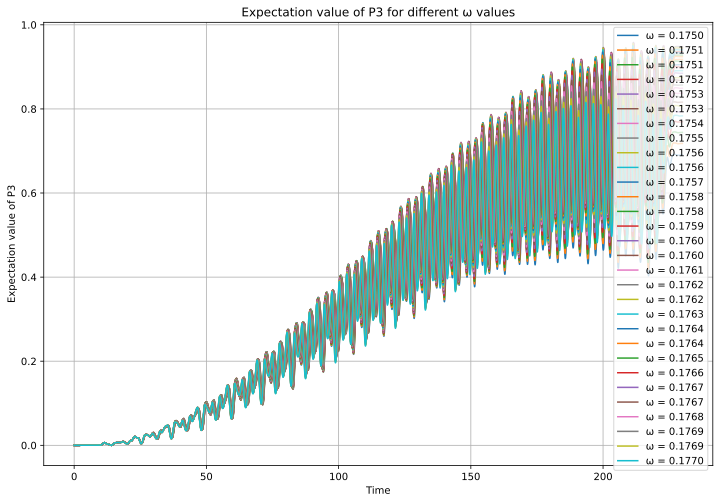

In [29]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Assuming all necessary functions and variables are defined earlier

def calculate_exp_P3(omega, H0, hc, psi0, PP3, tlist, drive_func):
    args = {'w': omega}
    H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P3 = np.array([qt.expect(PP2, state) for state in result.states])
    return exp_P3
psi0 = dressed_01
PP0 = dressed_00 *dressed_00.dag()
PP1 = dressed_01 *dressed_01.dag()
PP2 = dressed_10 *dressed_10.dag()
PP3 = dressed_11 *dressed_11.dag()
duration = 220
drive_func = gaussian_ramp(10, duration, 2.*2*np.pi)
omega_range = np.linspace(0.175, 0.177, 30) * 2 * np.pi  # 20 points between 1.276 and 1.28
tlist = np.linspace(0, duration+10, 12000)  # Cover ten periods

# Parallel computation
exp_P3_list = Parallel(n_jobs=-1)(delayed(calculate_exp_P3)(
    omega, H0, hc, psi0, PP3, tlist, drive_func) for omega in omega_range)

# Plotting
plt.figure(figsize=(12, 8))
for i, omega in enumerate(omega_range):
    plt.plot(tlist, exp_P3_list[i], label=f'ω = {omega/(2*np.pi):.4f}')

plt.xlabel('Time')
plt.ylabel('Expectation value of P3')
plt.title('Expectation value of P3 for different ω values')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
exp_P3_list = np.array(exp_P3_list)
max_omega= np.argmax(exp_P3_list[:,-1])
omega_range[max_omega]/2/np.pi

0.17610344827586205

If truncation of snail makes sense:

In [33]:

omega = omega_range[max_omega]
args = {'w': omega}
tlist = np.linspace(0, duration+10, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
result = qt.sesolve(H, psi0, tlist, args=args)


In [34]:
averages = []
for i in range(dims):
    # Compute the average value for this P
    avg = [qt.expect(qt.Qobj(Ps[i]), state) for state in result.states]
    averages.append(avg)
max(averages[-1])

5.950477757183856e-05

In [35]:
import numpy as np
import qutip as qt
from joblib import Parallel, delayed
def simulate_fidelity(duration, omega):
    drive_func = gaussian_ramp(30,duration, 2*2*np.pi)
    args = {'w': omega}
    tlist = np.linspace(0, duration+30, 10000)  # Cover ten periods
    # Hamiltonian with time-dependent part
    H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]

    # Solve the dynamics
    result = qt.sesolve(H, psi0, tlist, args={'w': omega})

    # Calculate expectation values
    exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
    
    # Return the final fidelity (last value of exp_P3)
    return exp_P2[-1]
durations = np.linspace(212,217,5)
frequencies = np.linspace(0.17613, 0.1762 , 5) * 2 * np.pi  # 3 steps from 0.698 to 0.700

# Parallel execution using joblib
results = Parallel(n_jobs=-1)(delayed(simulate_fidelity)( dur, freq)
                              for dur in durations
                              for freq in frequencies)


In [36]:
results_matrix = []
counter = 0
for i in range(len(durations)):
    row = []
    for j in range(len(frequencies)):
        row.append(results[counter])
        counter += 1
    results_matrix.append(row)
    # Printing frequencies for header
header = [" {:.5f} ".format(freq / (2 * np.pi)) for freq in frequencies]
print("          ", "  ".join(header))

# Print each row
for i, row in enumerate(results_matrix):
    print(f"Duration {durations[i]}: ", " ".join(f"{x:.6f}" for x in row))

            0.17613    0.17615    0.17617    0.17618    0.17620 
Duration 212.0:  0.999359 0.999453 0.999420 0.999256 0.998954
Duration 213.25:  0.999654 0.999741 0.999698 0.999549 0.999242
Duration 214.5:  0.999793 0.999892 0.999854 0.999675 0.999370
Duration 215.75:  0.999769 0.999864 0.999824 0.999641 0.999329
Duration 217.0:  0.999553 0.999649 0.999607 0.999426 0.999099


In [30]:
duration = 215.75
drive_func = gaussian_ramp(30,duration, 2*2*np.pi)
omega = 0.17617*2*np.pi
args = {'w': omega}
tlist = np.linspace(0, duration+30, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
result = qt.sesolve(H,dressed_01 , tlist, args=args)

In [31]:
exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
exp_P0 = np.array([qt.expect(PP0, state) for state in result.states])
exp_P3 = np.array([qt.expect(PP3, state) for state in result.states])
exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])

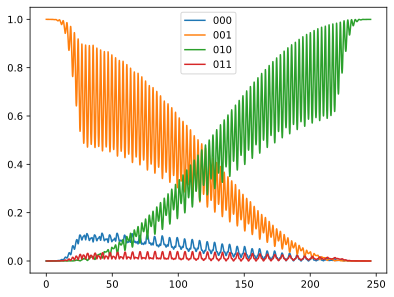

In [32]:
plt.plot(tlist,exp_P0,label = "000")
plt.plot(tlist,exp_P1,label = "001")
plt.plot(tlist,exp_P2,label = "010")
plt.plot(tlist,exp_P3,label="011")
plt.legend()

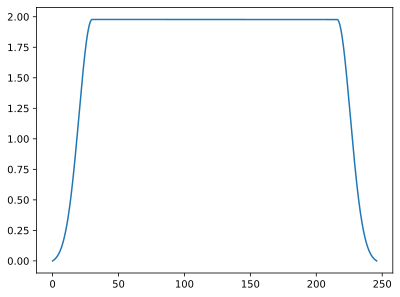

In [33]:
amplitude = []
for t in tlist:
    amplitude.append(drive_func(t)/2/np.pi)
from matplotlib import pyplot as plt
plt.plot(tlist,amplitude)

In [34]:
i0 = dressed_00
i1 = dressed_01
i2 = dressed_10
i3 = dressed_11
initial_states = [i0,i1,i2,i3]
duration = 215.75
drive_func = gaussian_ramp(30,duration, 2*2*np.pi)
omega = 0.17617*2*np.pi
args = {'w': omega}
tlist = np.linspace(0, duration+30, 10000)  # Cover ten periods
H = [H0, [hc, lambda t, args: drive_func(t)*np.cos(args['w']*t)]]
def evolve_state(psi0):
    result = qt.sesolve(H, psi0, tlist, args=args)
    return result.states[-1]
final_states = Parallel(n_jobs=-1)(delayed(evolve_state)(state) for state in initial_states)

In [35]:
basis_states = [dressed_00, dressed_01, dressed_10, dressed_11]
# Initialize the 4x4 matrix
evolution_matrix = np.zeros((4, 4), dtype=complex)

# Compute each element of the matrix
for i, final_state in enumerate(final_states):
    for j, basis_state in enumerate(basis_states):
        evolution_matrix[j, i] = basis_state.dag()* final_state


In [36]:
np.set_printoptions(precision=5, linewidth=120)
evolution_matrix = evolution_matrix/evolution_matrix[0][0]

In [37]:
evolution_matrix

array([[ 1.00000e+00-0.00000e+00j,  8.43373e-03+2.26182e-04j, -2.14019e-03+9.15032e-03j,  4.70573e-04+3.93795e-04j],
       [ 2.29082e-03+9.01767e-03j,  6.54934e-04+1.10072e-02j,  9.99817e-01-1.68617e-02j, -4.46606e-03-1.25172e-03j],
       [-2.69894e-03-8.08514e-03j,  2.87867e-01+9.57642e-01j, -1.05949e-02+2.72967e-03j, -6.47706e-05+4.41662e-03j],
       [ 4.98425e-04-3.09940e-04j,  4.40325e-03-3.69952e-04j, -4.62756e-03+3.13132e-04j, -9.72752e-01-2.32080e-01j]])

In [41]:
U1 = np.kron(np.array([[1,0],[0,evolution_matrix[1][2]]]),np.identity(2)) 
U2 = np.kron(np.identity(2),np.array([[1,0],[0,evolution_matrix[2][1]]]))
U1d = U1.conjugate().transpose()
U2d = U2.conjugate().transpose()

In [42]:
corrected_U = evolution_matrix@U1d@U2d

In [47]:
corrected_U[3,3] = 1

In [48]:
target = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

In [49]:
fidelity = np.abs(np.trace(target@corrected_U.conjugate().transpose()))**2/16

In [50]:
fidelity

0.9999321753682865